# Jun ??th, 2022 (entropy: k=7,10,14)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [7]:
_ = gr_ca.load_group()

In [8]:
gr_ca.run_pi.shape

(10, 3, 4, 300, 7, 152)

In [9]:
boot = bootstrap(gr_ca.run_pi, 100, 5, 4, est=bn.nanmean)

In [10]:
boot.shape

(100, 10, 3, 4, 7, 152)

<AxesSubplot:ylabel='Count'>

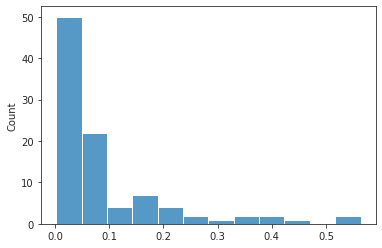

In [11]:
sns.histplot(boot[:, 9, 2, 1, 0, 51])

<AxesSubplot:ylabel='Count'>

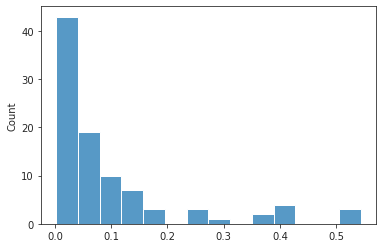

In [26]:
sns.histplot(boot[:, 9, 1, 3, 0, 51])

In [27]:
a = avg(gr_ca.run_pi, 2, 1)
a.shape

(10, 7, 152)

In [28]:
a[9, 0, 51]

0.12018750383051917

In [54]:
ci = 0.95
t = sp_stats.t.ppf(ci, 9)
t

1.8331129326536335

In [58]:
se = 1.4
sp_stats.t.sf(t * se, 9)

0.015184348075927622

### Ca2 (fast)

In [4]:
%%time

b = 0.5
mice.setup_func_data(task, band_ca=b)

pi_caf_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_ca2-fast.npy"
    pi_caf_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_caf_avg[lbl] = avg(pi_caf_pr.get(kk))
        
except FileNotFoundError:
    pi_caf_raw = {}
    pi_caf_pr = {}
    for kk in [7, 10, 14]:
        props_ca['num_k'] = kk
        gr_ca = Group(**props_ca).fit_group()
        pi_caf_raw[kk] = gr_ca.run_pi

        pi = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_caf_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_caf_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_caf_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_ca2-fast",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_caf_avg.copy()
for i in range(len(pi_caf_avg)):
    lbl, x = list(pi_caf_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 478 ms, sys: 797 ms, total: 1.27 s
Wall time: 1.27 s


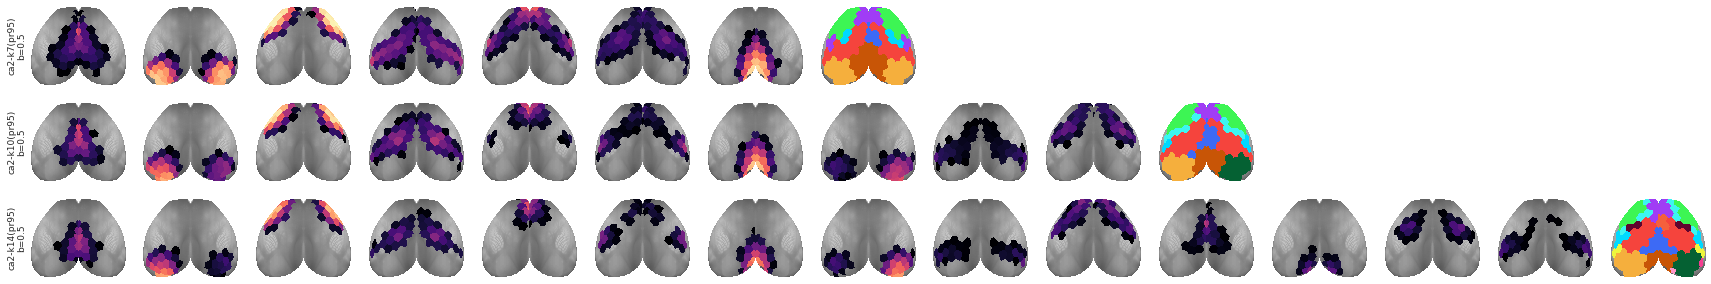

In [5]:
_ = gr_ca.show(d2p, figsize=(30, 5))

In [6]:
h_ca_all = []
for kk, x in pi_caf_pr.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_ca_all.append(np.expand_dims(h, 0))
h_ca_all = np.concatenate(h_ca_all)
h_ca_avg = avg(h_ca_all, 1, 1)

h_ca_all.shape, h_ca_avg.shape

((3, 10, 3, 4, 152), (3, 152))

In [7]:
np.nanmin(h_ca_avg), np.nanmax(h_ca_avg)

(0.04039400575949646, 0.815690086850833)

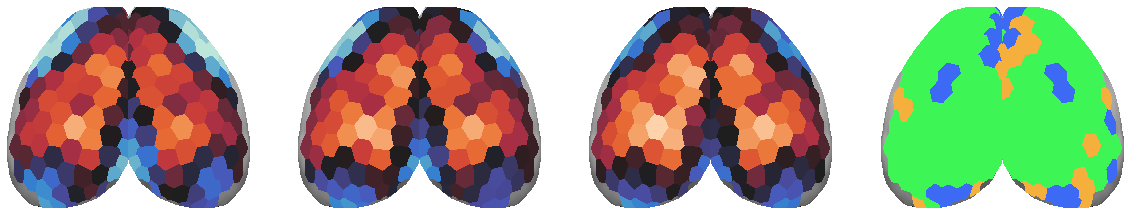

In [8]:
_ = gr_ca.show(
    h_ca_avg,
    vmin=np.nanmin(h_ca_avg),
    vmax=np.nanmax(h_ca_avg),
    figsize=(20, 4),
    cmap='icefire',
)

### Ca2 (slow)

In [9]:
%%time

b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

pi_ca_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_ca2-slow.npy"
    pi_ca_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_ca_avg[lbl] = avg(pi_ca_pr.get(kk))
        
except FileNotFoundError:
    pi_ca_raw = {}
    pi_ca_pr = {}
    for kk in [7, 10, 14]:
        props_ca['num_k'] = kk
        gr_ca = Group(**props_ca).fit_group()
        pi_ca_raw[kk] = gr_ca.run_pi

        pi = gr_ca.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_ca_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_ca_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_ca_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_ca2",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_ca_avg.copy()
for i in range(len(pi_ca_avg)):
    lbl, x = list(pi_ca_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 509 ms, sys: 857 ms, total: 1.37 s
Wall time: 1.36 s


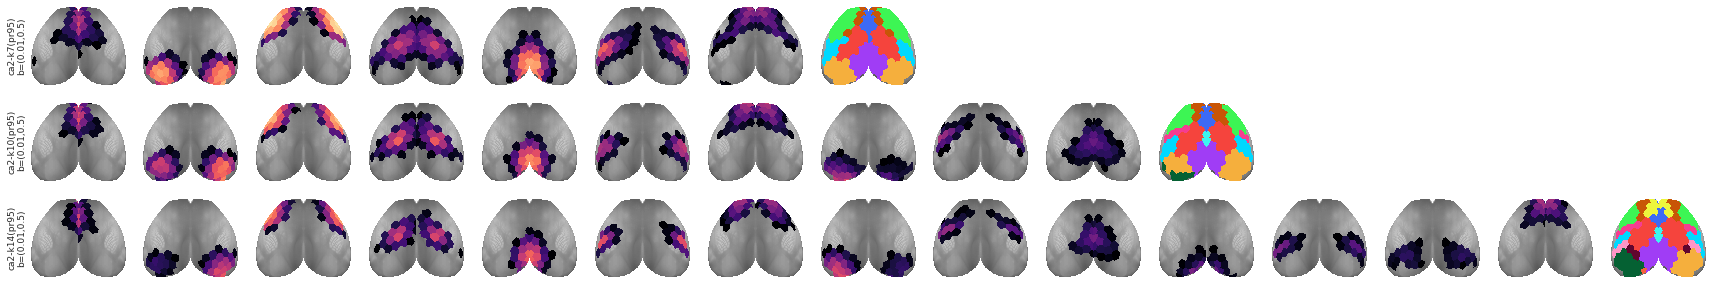

In [10]:
_ = gr_ca.show(d2p, figsize=(30, 5))

In [11]:
h_ca_all = []
for kk, x in pi_ca_pr.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_ca_all.append(np.expand_dims(h, 0))
h_ca_all = np.concatenate(h_ca_all)
h_ca_avg = avg(h_ca_all, 1, 1)

h_ca_all.shape, h_ca_avg.shape

((3, 10, 3, 4, 152), (3, 152))

In [12]:
np.nanmin(h_ca_avg), np.nanmax(h_ca_avg)

(0.07851595027138743, 0.6950613353220566)

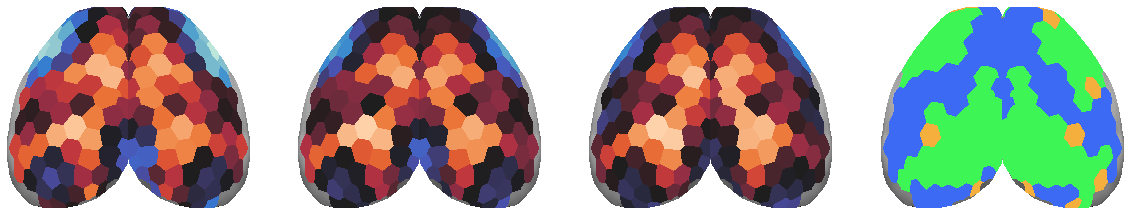

In [13]:
_ = gr_ca.show(
    h_ca_avg,
    vmin=np.nanmin(h_ca_avg),
    vmax=np.nanmax(h_ca_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [14]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_ca_avg, metric='correlation')))

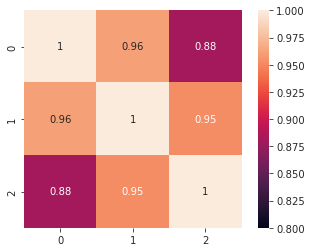

In [15]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

### Bold

In [16]:
%%time

pi_bo_avg = {}

try:
    f = f"pi-pr-dict_n{mice.cfg.nn}_bold.npy"
    pi_bo_pr = np.load(pjoin(tmp_dir, f), allow_pickle=True).item()
    for kk in [7, 10, 14]:
        lbl = f'bo-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_bo_avg[lbl] = avg(pi_bo_pr.get(kk))
        
except FileNotFoundError:
    pi_bo_raw = {}
    pi_bo_pr = {}
    for kk in [7, 10, 14]:
        props_bo['num_k'] = kk
        gr_bo = Group(**props_bo).fit_group()
        pi_bo_raw[kk] = gr_bo.run_pi

        pi = gr_bo.prune(thres=0.003, ci=0.95)['pi_prune']
        pi_bo_pr[kk] = pi

        lbl = f'ca2-k{kk}(pr95)\nb={b}'.replace(' ', '')
        pi_bo_avg[lbl] = avg(pi)
    
    save_obj(
        obj=pi_bo_pr,
        file_name=f"pi-pr-dict_n{mice.cfg.nn}_bold",
        save_dir=tmp_dir,
        mode='npy',
    )


# sort
d2p = pi_bo_avg.copy()
for i in range(len(pi_bo_avg)):
    lbl, x = list(pi_bo_avg.items())[i]
    if i == 0:
        continue
    src = list(d2p.values())[i - 1]
    gmap = find_best_mappings(
        centroids=src,
        data={0: x},
        match_metric='cosine',
        global_order='infer',
    )[0]
    ids = list(gmap.values())
    ids = ids + list(np.delete(range(len(x)), ids))
    d2p[lbl] = x[ids]

CPU times: user 813 ms, sys: 1.42 s, total: 2.23 s
Wall time: 2.23 s


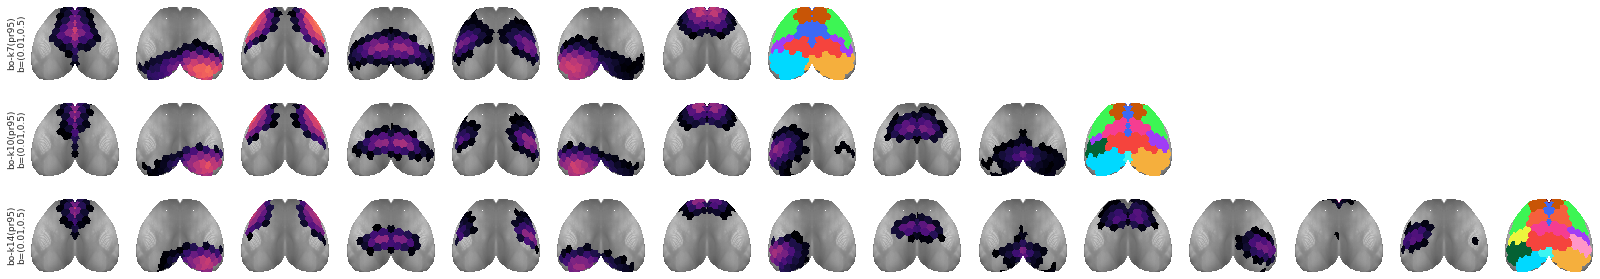

In [17]:
_ = gr_bo.show(d2p, figsize=(28, 5))

In [18]:
h_bo_all = []
for kk, x in pi_bo_pr.items():
    h = sp_stats.entropy(bn.nanmean(x, -3), axis=-2) / np.log(x.shape[-2])
    h_bo_all.append(np.expand_dims(h, 0))
h_bo_all = np.concatenate(h_bo_all)
h_bo_avg = avg(h_bo_all, 1, 1)

h_bo_all.shape, h_bo_avg.shape

((3, 10, 3, 4, 152), (3, 152))

In [19]:
np.nanmin(h_bo_avg), np.nanmax(h_bo_avg)

(0.3786339651316069, 0.7518628346075164)

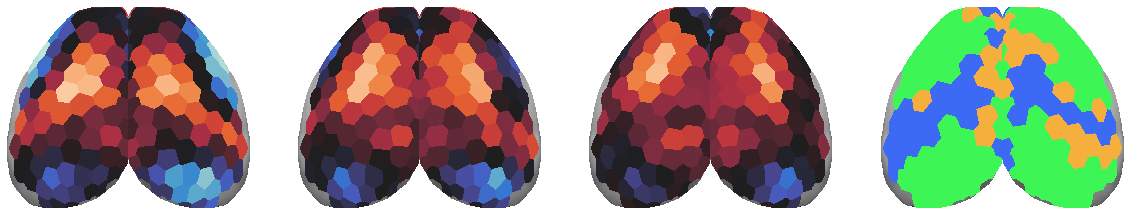

In [20]:
_ = gr_ca.show(
    h_bo_avg,
    vmin=np.nanmin(h_bo_avg),
    vmax=np.nanmax(h_bo_avg),
    figsize=(20, 4),
    cmap='icefire',
)

In [21]:
sim_h = dist2sim(sp_dist.squareform(sp_dist.pdist(
    h_bo_avg, metric='correlation')))

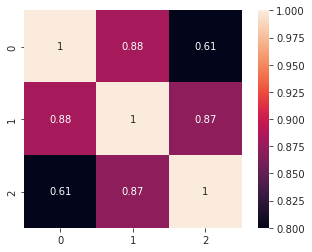

In [22]:
sns.heatmap(
    sim_h,
    vmin=0.8,
    vmax=1.0,
    square=True,
    annot=True,
    fmt='.2g',
)
plt.show()

## Compare (run level)

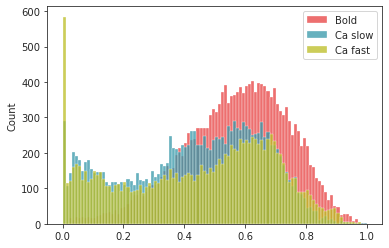

In [23]:
kk = 7
h1 = sp_stats.entropy(bn.nanmean(pi_bo_pr[kk], -3), axis=-2) / np.log(kk)
h2 = sp_stats.entropy(bn.nanmean(pi_ca_pr[kk], -3), axis=-2) / np.log(kk)
h3 = sp_stats.entropy(bn.nanmean(pi_caf_pr[kk], -3), axis=-2) / np.log(kk)

sns.histplot(h1[np.isfinite(h1)], bins=np.linspace(0, 1, 101), color=pal['bold-lite'], label='Bold')
sns.histplot(h2[np.isfinite(h2)], bins=np.linspace(0, 1, 101), color=pal['ca2'], label='Ca slow')
sns.histplot(h3[np.isfinite(h3)], bins=np.linspace(0, 1, 101), color='C8', label='Ca fast')
plt.legend()
plt.show()

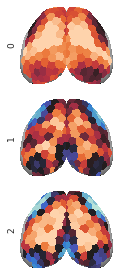

In [24]:
h1, h2, h3 = avg(h1, 1), avg(h2, 1), avg(h3, 1)
vmin = min(np.nanmin(h1), np.nanmin(h2), np.nanmin(h3))
vmax = min(np.nanmax(h1), np.nanmax(h2), np.nanmax(h3))
_ = gr_ca.show([h1, h2, h3], vmin=vmin, vmax=vmax, cmap='icefire', add_disjoint=False)

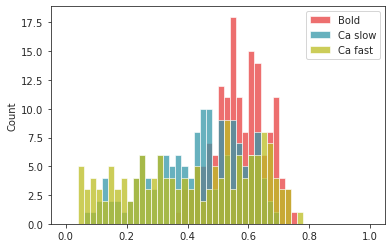

In [25]:
sns.histplot(h1[np.isfinite(h1)], bins=np.linspace(0, 1, 51), color=pal['bold-lite'], label='Bold')
sns.histplot(h2[np.isfinite(h2)], bins=np.linspace(0, 1, 51), color=pal['ca2'], label='Ca slow')
sns.histplot(h3[np.isfinite(h3)], bins=np.linspace(0, 1, 51), color='C8', label='Ca fast')
plt.legend()
plt.show()

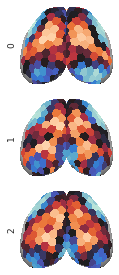

In [26]:
hr1 = sp_stats.rankdata(h1)
hr2 = sp_stats.rankdata(h2)
hr3 = sp_stats.rankdata(h3)
vmin = min(np.nanmin(hr1), np.nanmin(hr2), np.nanmin(hr3))
vmax = min(np.nanmax(hr1), np.nanmax(hr2), np.nanmax(hr3))
_ = gr_ca.show([hr1, hr2, hr3], vmin=vmin, vmax=vmax, cmap='icefire', add_disjoint=False)

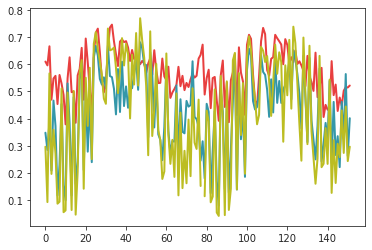

In [27]:
plt.plot(h1, lw=2, color=pal['bold-lite'])
plt.plot(h2, lw=2, color=pal['ca2'])
plt.plot(h3, lw=2, color='C8')
plt.show()

In [28]:
sp_stats.pearsonr(h1, h2)

(0.5966919777089308, 4.974464569893051e-16)

In [29]:
sp_stats.spearmanr(h1, h2)

SpearmanrResult(correlation=0.5502361279123011, pvalue=2.089066526943023e-13)

In [30]:
sp_stats.pearsonr(hr1, hr2)

(0.5502361279123011, 2.0890665269430025e-13)

In [31]:
def corr(x, y, kind='spearman'):
    good = np.logical_and(np.isfinite(x), np.isfinite(y))
    if kind == 'spearman':
        return sp_stats.spearmanr(x[good], y[good]).correlation
    elif kind == 'pearson':
        return sp_stats.pearsonr(x[good], y[good])[0]

In [32]:
msg = '--- Spearman r ---\n\n'
msg += f"BOLD vs. Ca (slow):  {corr(h1, h2, 'spearman'):0.3f}\n"
msg += f"BOLD vs. Ca (fast):  {corr(h1, h3, 'spearman'):0.3f}\n"
msg += f"Ca (slow) vs. Ca (fast):  {corr(h2, h3, 'spearman'):0.3f}\n"
print(msg)

--- Spearman r ---

BOLD vs. Ca (slow):  0.550
BOLD vs. Ca (fast):  0.642
Ca (slow) vs. Ca (fast):  0.886

In [33]:
msg = '--- Pearson r ---\n\n'
msg += f"BOLD vs. Ca (slow):  {corr(h1, h2, 'pearson'):0.3f}\n"
msg += f"BOLD vs. Ca (fast):  {corr(h1, h3, 'pearson'):0.3f}\n"
msg += f"Ca (slow) vs. Ca (fast):  {corr(h2, h3, 'pearson'):0.3f}\n"
print(msg)

--- Pearson r ---

BOLD vs. Ca (slow):  0.597
BOLD vs. Ca (fast):  0.641
Ca (slow) vs. Ca (fast):  0.899

In [34]:
df = {
    'Bold': h1,
    'Ca2 (slow)': h2,
    'Ca2 (fast)': h3,
}
df = pd.DataFrame(df)

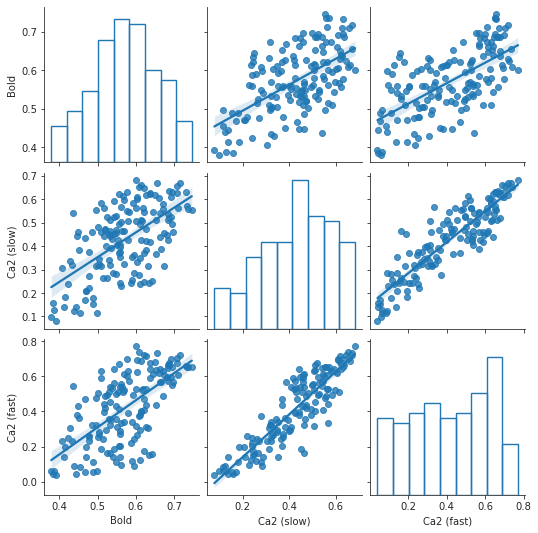

In [35]:
sns.pairplot(df, kind='reg', diag_kws={'fill': False});

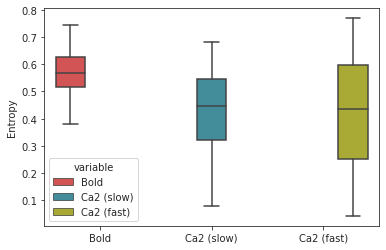

In [36]:
sns.boxplot(
    data=df.melt(),
    y='value',
    x='variable',
    hue='variable',
    palette={
        'Bold': pal['bold-lite'],
        'Ca2 (slow)': pal['ca2'],
        'Ca2 (fast)': 'C8',
    },
)
plt.ylabel('Entropy')
plt.xlabel('')
plt.show()

## Histogram plot

In [37]:
bins = np.linspace(0.2, 1, 5)
bins

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [38]:
kk = 7
pi_bo = pi_bo_pr[kk]
pi_ca = pi_ca_pr[kk]
pi_caf = pi_caf_pr[kk]

In [39]:
cut_bo = cut_data(
    data=pi_bo.reshape(-1, *pi_bo.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_bo.shape[:4], pi_bo.shape[-2], -1)
cut_avg_bo = avg(cut_bo)

cut_ca = cut_data(
    data=pi_ca.reshape(-1, *pi_ca.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_ca.shape[:4], pi_ca.shape[-2], -1)
cut_avg_ca = avg(cut_ca)
cut_ca.shape, cut_avg_ca.shape

cut_caf = cut_data(
    data=pi_caf.reshape(-1, *pi_caf.shape[-2:]),
    bins=bins,
    oc_only=True,
)[0].reshape(*pi_caf.shape[:4], pi_caf.shape[-2], -1)
cut_avg_caf = avg(cut_caf)


cut_bo.shape, cut_avg_bo.shape

((10, 3, 4, 500, 7, 4), (7, 4))

In [40]:
colors = get_cluster_cmap(range(kk), True)[1]

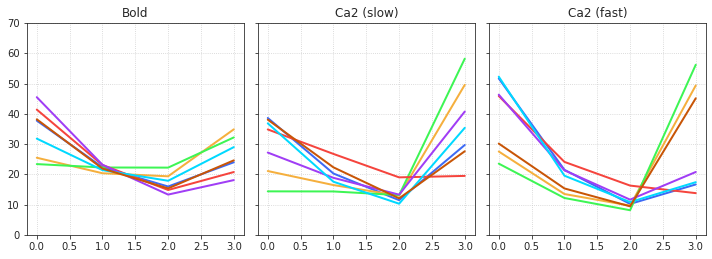

In [42]:
fig, axes = create_figure(1, 3, (10, 3.7), 'all', 'all')

for i, c in enumerate(colors):
    axes[0].plot(cut_avg_bo[i], color=c, lw=2)
    axes[1].plot(cut_avg_ca[i], color=c, lw=2)
    axes[2].plot(cut_avg_caf[i], color=c, lw=2)
    
    axes[0].set_title('Bold')
    axes[1].set_title('Ca2 (slow)')
    axes[2].set_title('Ca2 (fast)')

axes[-1].set_ylim(0, 70)
add_grid(axes)
plt.show()

## Entropy plot

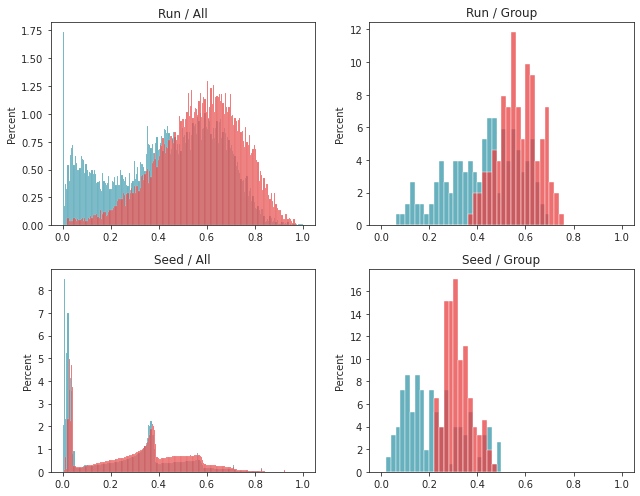

In [43]:
fig, axes = create_figure(2, 2, (9, 7))

h_ca = sp_stats.entropy(bn.nanmean(pi_ca, -3), axis=-2) / np.log(kk)
h_bo = sp_stats.entropy(bn.nanmean(pi_bo, -3), axis=-2) / np.log(kk)
h_ca_avg = avg(h_ca, 1)
h_bo_avg = avg(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[0, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[0, 1],
)
axes[0, 0].set_title('Run / All')
axes[0, 1].set_title('Run / Group')


h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(kk)
h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(kk)
h_ca_avg = avg(h_ca, 1)
h_bo_avg = avg(h_bo, 1)

sns.histplot(
    h_ca[np.isfinite(h_ca)],
    bins=np.linspace(0, 1, 201),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_bo[np.isfinite(h_bo)],
    bins=np.linspace(0, 1, 201),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 0],
)
sns.histplot(
    h_ca_avg[np.isfinite(h_ca_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['ca2'],
    stat='percent',
    ax=axes[1, 1],
)
sns.histplot(
    h_bo_avg[np.isfinite(h_bo_avg)],
    bins=np.linspace(0, 1, 51),
    color=pal['bold-lite'],
    stat='percent',
    ax=axes[1, 1],
)
axes[1, 0].set_title('Seed / All')
axes[1, 1].set_title('Seed / Group')

#for ax in axes.flat:
#    ax.legend()
plt.show()

In [44]:
bins = np.linspace(0, 1, 51)
xx = (bins[:-1] + bins[1:]) / 2

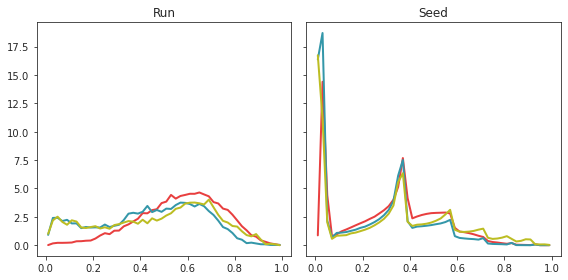

In [45]:
fig, axes = create_figure(1, 2, (8, 4), 'all', 'all')


h_bo = sp_stats.entropy(bn.nanmean(pi_bo, -3), axis=-2) / np.log(kk)
h_ca = sp_stats.entropy(bn.nanmean(pi_ca, -3), axis=-2) / np.log(kk)
h_caf = sp_stats.entropy(bn.nanmean(pi_caf, -3), axis=-2) / np.log(kk)


cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:3], -1)
cut_avg_bo = avg(cut_bo, 1)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:3], -1)
cut_avg_ca = avg(cut_ca, 1)

cut_caf = cut_data(
    data=h_caf.reshape(-1, 1, h_caf.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_caf.shape[:3], -1)
cut_avg_caf = avg(cut_caf, 1)


axes[0].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[0].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[0].plot(xx, cut_avg_caf, color='C8', lw=2)
axes[0].set_title('Run')


h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(kk)
h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(kk)
h_caf = sp_stats.entropy(pi_caf, axis=-2) / np.log(kk)

cut_bo = cut_data(
    data=h_bo.reshape(-1, 1, h_bo.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_bo.shape[:4], -1)
cut_avg_bo = avg(cut_bo, 1)

cut_ca = cut_data(
    data=h_ca.reshape(-1, 1, h_ca.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_ca.shape[:4], -1)
cut_avg_ca = avg(cut_ca, 1)

cut_caf = cut_data(
    data=h_caf.reshape(-1, 1, h_caf.shape[-1]),
    bins=bins,
    oc_only=True,
)[0].reshape(*h_caf.shape[:4], -1)
cut_avg_caf = avg(cut_caf, 1)

axes[1].plot(xx, cut_avg_bo, color=pal['bold-lite'], lw=2)
axes[1].plot(xx, cut_avg_ca, color=pal['ca2'], lw=2)
axes[1].plot(xx, cut_avg_caf, color='C8', lw=2)
axes[1].set_title('Seed')
plt.show()

## Corr analysis

In [38]:
d2p = {}
ent_run = {}
ent_grp = {}

kk = 7
props_ca['num_k'] = kk
gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)

h = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
ent_run[kk] = h
ent_grp[kk] = apply_fn(h, 1)

gr_ca.avg(pi_ca)
d2p[f'ca2-k7(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())


kk = 10
props_ca['num_k'] = kk
gr_ca = Group(**props_ca).fit_group()
pruned_ca = gr_ca.prune(thres=0.003, ci=0.95)
pi_ca = gr_ca.align_post_prune(pruned_ca['pi_prune_run'])[0]
pi_run_ca = bn.nanmean(pi_ca, -3)

h = sp_stats.entropy(pi_run_ca, axis=-2) / np.log(gr_ca.num_k)
ent_run[kk] = h
ent_grp[kk] = apply_fn(h, 1)

gr_ca.avg(pi_ca)
d2p[f'ca2-k10(pr95)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

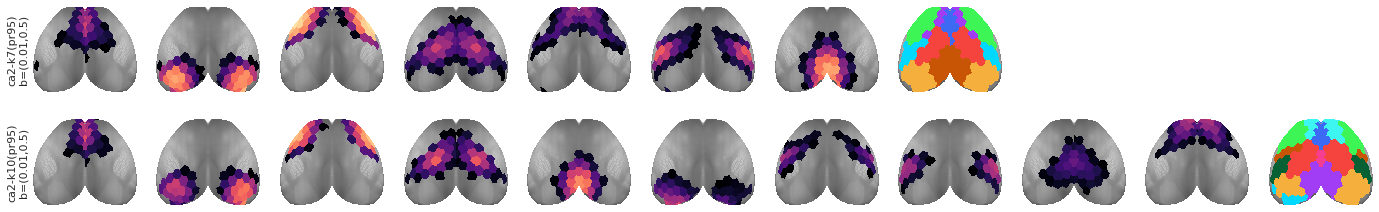

In [39]:
_ = quick_show(d2p, vmax=1.0, figsize=(24, 3.8), ylabel_fontsize=11)

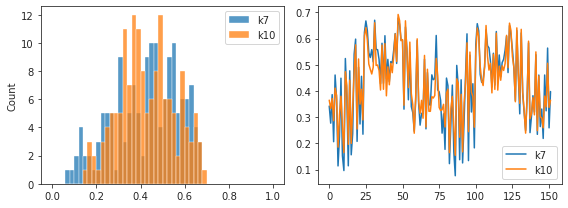

In [49]:
fig, axes = create_figure(1, 2, (8, 3.))

for i, (kk, h) in enumerate(ent_grp.items()):
    sns.histplot(h, bins=np.linspace(0, 1, 51), label=f"k{kk}", color=f'C{i}', ax=axes[0])
    axes[1].plot(h, label=f"k{kk}", color=f'C{i}')
for ax in axes.flat:
    ax.legend()
plt.show()

In [50]:
sp_stats.pearsonr(ent_grp[7], ent_grp[10])

(0.9604044529741587, 3.800829554597059e-85)

In [63]:
r_all = []
for i in range(120):
    x = ent_run[7].reshape(-1, ent_run[7].shape[-1])[i]
    y = ent_run[10].reshape(-1, ent_run[7].shape[-1])[i]
    good = np.logical_and(np.isfinite(x), np.isfinite(y))
    if not good.sum():
        continue
    r = sp_stats.pearsonr(x[good], y[good])[0]
    r_all.append(r)
len(r_all)

110

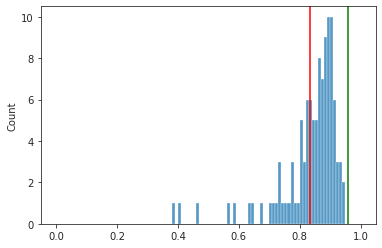

In [69]:
sns.histplot(r_all, bins=np.linspace(0, 1, 101))
plt.axvline(np.mean(r_all), color='r')
plt.axvline(sp_stats.pearsonr(ent_grp[7], ent_grp[10])[0], color='g')
plt.show()

## H

In [163]:
trh_ca_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_ca_10, add_disjoint=False))
trh_bo_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_10, add_disjoint=False))
trh_bo_11 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_11, add_disjoint=False))
trh_bo_mg = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_mg, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca_10), np.nanmin(h_avg_bo_10), np.nanmin(h_avg_bo_11), np.nanmin(h_avg_bo_mg))
vmax = max(np.nanmax(h_avg_ca_10), np.nanmax(h_avg_bo_10), np.nanmax(h_avg_bo_11), np.nanmax(h_avg_bo_mg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.23037689538563905, 0.724035911433707)

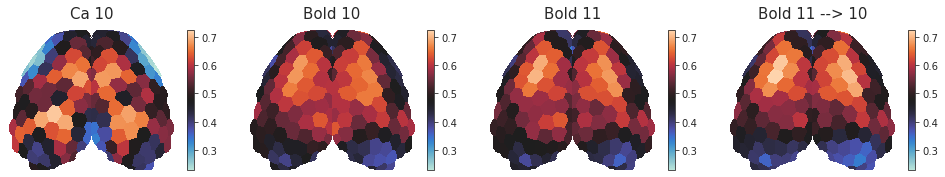

In [141]:
fig, axes = create_figure(1, 4, (13.5, 2.4))

im = axes[0].imshow(mwh(trh_ca_10['proj-top'][0] < vmin, trh_ca_10['proj-top'][0]), **kw_im)
axes[0].set_title('Ca 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_bo_10['proj-top'][0] < vmin, trh_bo_10['proj-top'][0]), **kw_im)
axes[1].set_title('Bold 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_bo_11['proj-top'][0] < vmin, trh_bo_11['proj-top'][0]), **kw_im)
axes[2].set_title('Bold 11', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(mwh(trh_bo_mg['proj-top'][0] < vmin, trh_bo_mg['proj-top'][0]), **kw_im)
axes[3].set_title('Bold 11 --> 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[3])

remove_ticks(axes)
plt.show()

In [142]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_mg)

(0.9207048579946774, 3.561061905557345e-63)

In [143]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_11)

(0.9580061746150019, 2.8609405138619793e-83)

In [144]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_bo_11)

(0.9634534518516699, 1.045062568998126e-87)

In [147]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_ca_10)

(0.4332918165008459, 2.4652039288401117e-08)

In [148]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_ca_10)

(0.3801225500857732, 1.3629250608234312e-06)

### Conclusion: for entropy do not use mg, mg is just for visualization of communities
- For other statistics also do not use mg, just find out how to cut data from say num k = 11 and then somehow average the two communities to be mg-ed and that gives u a single number for that community

## Difference map

In [245]:
from statsmodels.stats.multitest import fdrcorrection

### ca slow vs bo (kk = 7)

In [246]:
kk = 7
pi_bo = bn.nanmean(pi_bo_pr[kk], -3)
pi_ca = bn.nanmean(pi_ca_pr[kk], -3)
pi_caf = bn.nanmean(pi_caf_pr[kk], -3)

h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(kk)
h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(kk)
h_caf = sp_stats.entropy(pi_caf, axis=-2) / np.log(kk)

In [247]:
y1 = h_bo.reshape(-1, h_bo.shape[-1])
y2 = h_ca.reshape(-1, h_ca.shape[-1])
y3 = h_caf.reshape(-1, h_caf.shape[-1])
y1.shape, y2.shape, y3.shape

((120, 152), (120, 152), (120, 152))

In [248]:
def statistic(a, b, axis):
    # print(a.shape, b.shape, axis)
    return bn.nanmean(a - b, axis=axis)

In [249]:
%%time

test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

CPU times: user 6.25 s, sys: 2.87 ms, total: 6.25 s
Wall time: 6.25 s


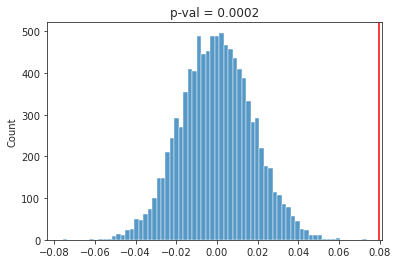

In [250]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

In [251]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(126, True)

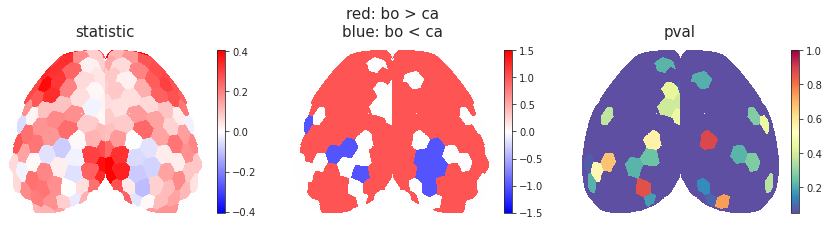

In [252]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(pvals_corrected, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [253]:
test = sp_stats.permutation_test(
    data=(y1, y3),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [254]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(120, True)

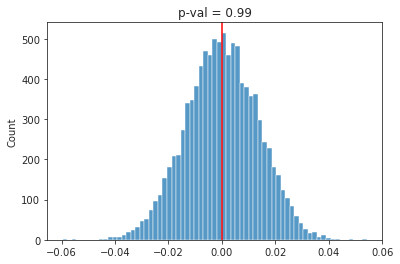

In [255]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

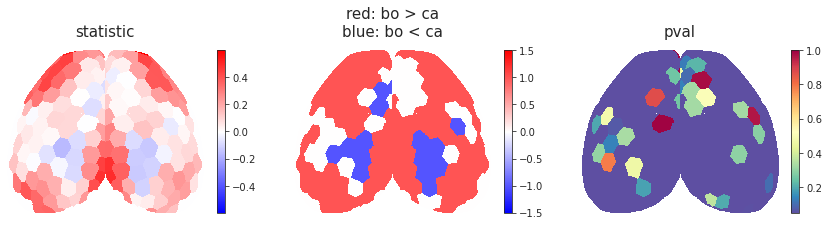

In [256]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(pvals_corrected, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [257]:
test = sp_stats.permutation_test(
    data=(y2, y3),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [258]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(96, True)

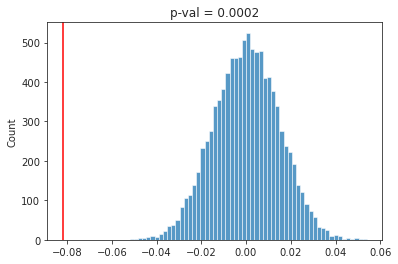

In [259]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

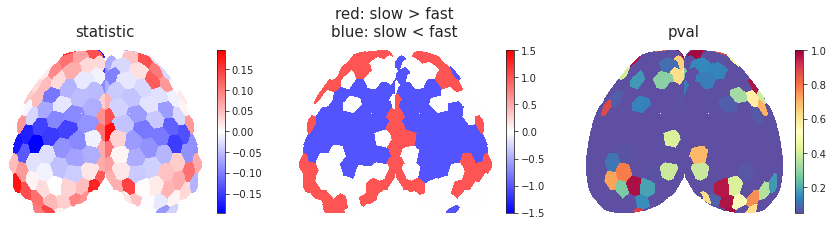

In [260]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(pvals_corrected, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: slow > fast\nblue: slow < fast', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

## Difference map (other stat, or rank?)

In [167]:
from statsmodels.stats.multitest import fdrcorrection

### ca slow vs bo (kk = 7)

In [168]:
kk = 7
pi_bo = bn.nanmean(pi_bo_pr[kk], -3)
pi_ca = bn.nanmean(pi_ca_pr[kk], -3)
pi_caf = bn.nanmean(pi_caf_pr[kk], -3)

h_bo = sp_stats.entropy(pi_bo, axis=-2) / np.log(kk)
h_ca = sp_stats.entropy(pi_ca, axis=-2) / np.log(kk)
h_caf = sp_stats.entropy(pi_caf, axis=-2) / np.log(kk)

In [135]:
"""hr_bo = np_nans(h_bo.shape)
hr_ca = np_nans(h_ca.shape)
hr_caf = np_nans(h_caf.shape)

for i, j, k in itertools.product(range(10), range(3), range(4)):
    x = h_bo[i, j, k]
    good = np.isfinite(x)
    hr_bo[i, j, k][good] = sp_stats.rankdata(x[good])
    
    x = h_ca[i, j, k]
    good = np.isfinite(x)
    hr_ca[i, j, k][good] = sp_stats.rankdata(x[good])
    
    x = h_caf[i, j, k]
    good = np.isfinite(x)
    hr_caf[i, j, k][good] = sp_stats.rankdata(x[good])"""

In [169]:
y1 = h_bo.reshape(-1, h_bo.shape[-1])
y2 = h_ca.reshape(-1, h_ca.shape[-1])
y3 = h_caf.reshape(-1, h_caf.shape[-1])

good_runs = ~np.logical_or(
    np.isnan(y1).sum(1) == y1.shape[-1],
    np.isnan(y2).sum(1) == y2.shape[-1],
    np.isnan(y3).sum(1) == y3.shape[-1],
)
good_runs.sum()

108

In [170]:
y1 = y1[good_runs]
y2 = y2[good_runs]
y3 = y3[good_runs]

In [171]:
def statistic(a, b, axis):
    ##print(a.shape, b.shape, axis)
    return bn.nanmean(a - b, axis=axis)

In [172]:
good_nodes = np.logical_and(
    np.isnan(y1).sum(0) < good_runs.sum() // 2,
    np.isnan(y2).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

146

In [173]:
%%time

test = sp_stats.permutation_test(
    data=(y1[:, good_nodes], y2[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

CPU times: user 580 ms, sys: 19.9 ms, total: 600 ms
Wall time: 601 ms


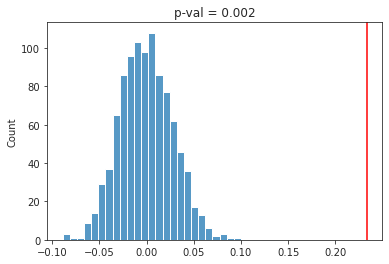

In [174]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

In [175]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(122, True)

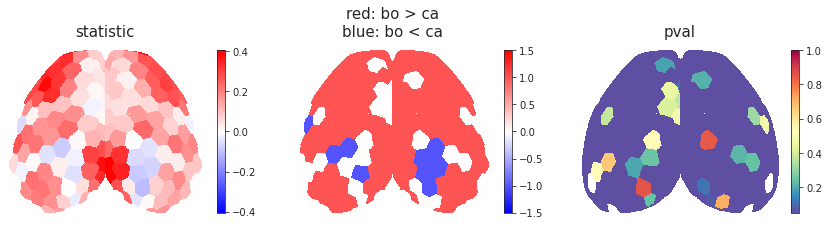

In [176]:
_statistic = np_nans(len(h1))
_pvalues = np_nans(len(h1))

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected


tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [188]:
def statistic(a, b):
    return sp_stats.spearmanr(a, b, nan_policy='omit').correlation

In [189]:
good_nodes = np.logical_and(
    np.isnan(y1).sum(0) < good_runs.sum() // 2,
    np.isnan(y2).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

146

In [219]:
good_nodes = np.where(good_nodes)[0]

In [220]:
statistic(y1[:, good_nodes[0]], y2[:, good_nodes[0]])

0.15874355368026255

In [227]:
%%time

_statistic = np_nans(len(h1))
_pvalues = np_nans(len(h1))

for i in tqdm(good_nodes):
    test = sp_stats.permutation_test(
        data=(y1[:, i], y2[:, i]),
        statistic=statistic,
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(1e2),
        random_state=42,
        batch=5,
    )
    _statistic[i] = test.statistic
    _pvalues[i] = test.pvalue

  0%|          | 0/146 [00:00<?, ?it/s]

CPU times: user 19.3 s, sys: 58.3 ms, total: 19.4 s
Wall time: 19.3 s


In [238]:
rejected, pvals_corrected = fdrcorrection(_pvalues[np.isfinite(_pvalues)], method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(106, True)

In [241]:
pvals_corrected_final = np_nans(len(_pvalues))
pvals_corrected_final[np.isfinite(_pvalues)] = pvals_corrected

In [242]:
rejected_final = np_nans(len(_pvalues))
rejected_final[np.isfinite(_pvalues)] = rejected

In [240]:
rejected_final

array([ 1.,  1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        1., nan,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1., nan,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
       nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1., nan,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0., nan,  0.,  0.,  0.,  1.,  1.])

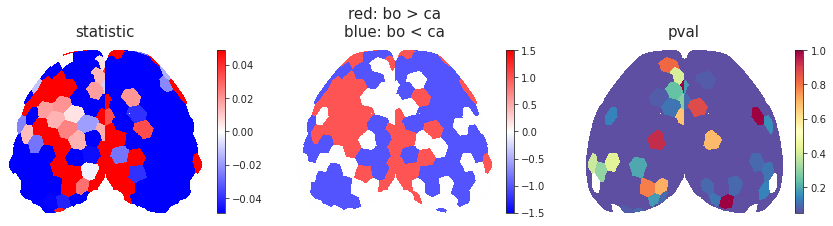

In [244]:
tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(pvals_corrected_final, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [130]:
good_nodes = np.logical_and(
    np.isnan(y1).sum(0) < good_runs.sum() // 2,
    np.isnan(y3).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

122

In [131]:
test = sp_stats.permutation_test(
    data=(y1[:, good_nodes], y3[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [132]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(98, True)

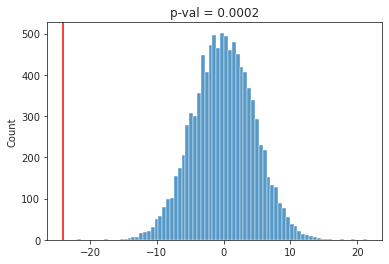

In [82]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

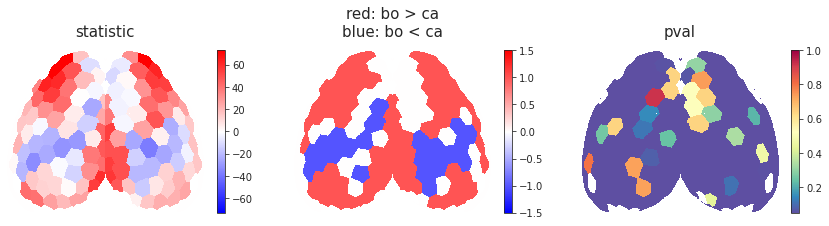

In [83]:
_statistic = np_nans(len(h1))
_pvalues = np_nans(len(h1))

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected


tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

In [84]:
good_nodes = np.logical_and(
    np.isnan(y2).sum(0) < good_runs.sum() // 2,
    np.isnan(y3).sum(0) < good_runs.sum() // 2,
)
good_nodes.sum()

122

In [85]:
test = sp_stats.permutation_test(
    data=(y2[:, good_nodes], y3[:, good_nodes]),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e4),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [86]:
rejected, pvals_corrected = fdrcorrection(test.pvalue, method='p')
rejected.sum(), np.array_equal(pvals_corrected < 0.05, rejected)

(104, True)

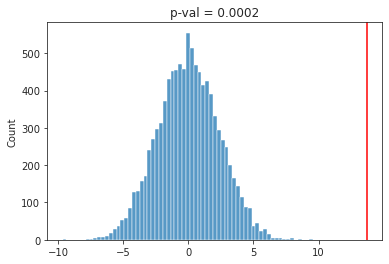

In [87]:
ii = 38

sns.histplot(test.null_distribution[:, ii])
plt.axvline(test.statistic[ii], color='r')
plt.title(f"p-val = {test.pvalue[ii]:0.2g}")
plt.show()

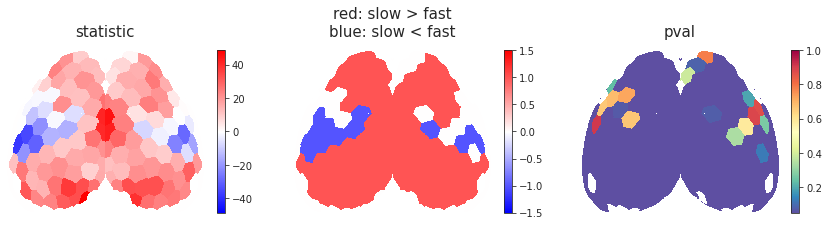

In [88]:
_statistic = np_nans(len(h1))
_pvalues = np_nans(len(h1))

_statistic[good_nodes] = test.statistic
_pvalues[good_nodes] = pvals_corrected


tr_statistic = gr_ca.project_vec(_statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue_corrected = gr_ca.project_vec(_pvalues, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue_corrected = gr_ca.trim2d(tr_pvalue_corrected)


fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.nanmax(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue_corrected['proj-top'][0] >= alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: slow > fast\nblue: slow < fast', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue_corrected['top'] == 0, tr_pvalue_corrected['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()